# Optimizing Physical Systems

To learn about optimization, we'll focus on the simple example of a projectile, like a cannonball being fired from a cannon.

Assuming the cannonball comes out of the barrel at the same speed every time, the launch angle will decide the trajectory as seen below.

![Projectile trajectories](pics/projectile_trajectories.png)

By looking at the picture you can see that 80° is the trajectory that sends the cannonball the highest, and 45° the trajectory that sends the cannonball the furthest. Our goal is to systematically explore the range of possible launch angles to be able to obtain the trajectory that optimizes the launch between 0° and 90°.

To do this, we will build a simulator for the cannonball using a Python function `landing_position` that takes a launch angle as input, then runs Euler's method (as seen [Simulating moving objects](../08_simulating-moving-objects/08_simulating-moving-objects.ipynb)) and returns the range of the cannonball at that angle.

With that function in place, we can think about the problem of finding the launch angle that maximizes the range. We can find that angle by either:
- making a graph of the range vs. launch angle and look for the largest value using our simulator
- find a formula for the range $ r(\theta) $ of the projectile as a function of the launch angle $ \theta $.

Both approaches should produce identical results.

In particular, when using the formula we will be able to take its derivative. The derivative of the landing position with respect to the launch angle will tell us how much increase in the range we'll get for small increases in the launch angle.

At some angle, we will start getting diminishing returns (increasing the launch angle will cause the range to decrease) which means we'd have passed our optimal value. Before this, the derivative of $ r(\theta) $ will be zero, and the value of $ \theta $ where the derivative is zero happens to be at the maximum value.

Afterwards, we will run a more challenging 3D simulation in which we will be able to control the upward angle of the cannon, as well as the lateral direction. This might have an impact in real scenarios where the terrain varies around the cannon.

In this case, we will build a function $ r(\theta, \phi) $ that will output the final landing position of the projectile. We will look for the pair $ (\theta, \phi) $ that maximizes the range of the cannon. For this case we will use an important optimization technique called the *gradient ascent*.

We'll write a Python function `gradient_ascent` that will take as input a function to optimize, along with a pair of starting inputs, and will use the gradient to find higher and higher values until it reaches the optimal value.

## Testing a projectile simulation

In this section we will build a simulator that computes the flight path of the cannonball.

It will be implemented via a function called `trajectory` that will take the launch angle, as well as other few parameters that we may want to control, and will return the possitions of the cannonball over time until it collides with earth. To build the simulation we will rely on the Euler's method.

As a reminder, Euler's method lets you simulate motion by advancing through time in small increments (such as 0.01 seconds). At each moment, we'll know the position of the cannonball, as well as it's derivatives that give us the velocity and acceleration respectively.

The velocity and acceleration will let us approximate the change in position to the next moment. The process will be repeated until the cannonball hits the ground. In each iteration we will be storing the $ x $ and $ y $ positions, which we will return once the `trajectory` function completes.

Finally, we'll write functions that take the results from the `trajectory` function and will give us metrics such as `landing_position`, `hang_time`, and `max_height`. Those will be the values subject of being optimized.

### Building a simulation with Euler's method

For our simulation, we call the horizontal direction $ x $ and the vertical direction $ z $ (so that we don't have to rename them when we tackle the 3D simulation).

The angle of the cannon will be $ theta $ and the velocity of the cannon will be $ \vec{v} $.

![Cannon variables](pics/cannon-variables.png)

The speed, $ v $, of a moving object is the magnitude of its velocity. Thus, $ v = |\vec{v}| $.

Using trigonometry, we can say:

$
v_x = |v| \cdot cos(\theta) \\
v_y = |v| \cdot sin(\theta)
$

We should also include the height at which the cannon is placed as a parameter.

With all that information in place, we can write the implementation of the `trajectory` function:

In [1]:
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(xs)
        zs.append(zs)
    return ts, xs, zs

We can start using this function to get trajectories for different angles, speed and heights.

A `plot_trajectories` function will also be useful to visualize those trajectories

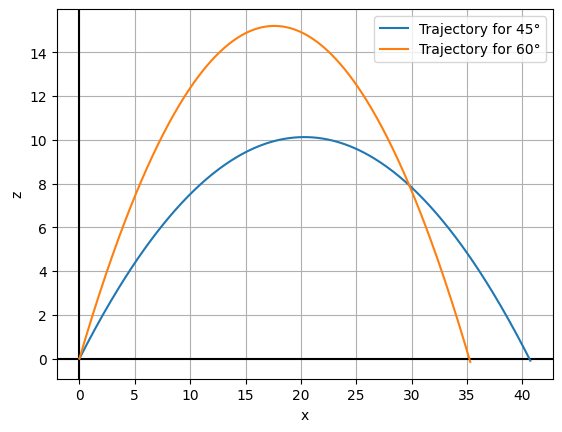

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi

def trajectory(theta_deg, speed=20, height=0, dt=0.01, g=-9.81):
    vx = speed * cos(pi * theta_deg / 180)
    vz = speed * sin(pi * theta_deg / 180)
    t, x, z = 0, 0, height
    ts, xs, zs = [t], [x], [z]
    while z >= 0:
        t += dt
        vz += g * dt
        x += vx * dt
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)

    label = f"Trajectory for {theta_deg}°"
    if speed != 20:
        label += f" and speed {speed}"
    if height != 0:
        label += f" and height {height}"

    return ts, xs, zs, label

ts, xs, zs, label = trajectory(45)

def plot_trajectories(*trajectories):
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_xlabel("x")
    ax.set_ylabel("z")

    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")

    for _, xs, zs, label in trajectories:
        ax.plot(xs, zs, label=label)

    ax.legend()
    plt.show()

plot_trajectories(
    trajectory(45),
    trajectory(60),
    )





We see that the 45° launch angle produces a greater range and that the 60° launch angle produces a greater maximum height.

### Measuring properties of the trajectory

While it's useful to keep the raw output of the trajectory (e.g., to plot it) sometime we'll want to focus on a specific metric.

For instance, we might want to get the range of the projectile (which is the last x position) before the cannonball hits the ground.

In [ ]:
def landing_position(traj):
    """
    returns the last x position of a trajectory before
    the projectile hits the ground
    """
    return traj[1][-1]

Some other interesting metrics are the *hanging time* (how long the projectile stays in the air) and the maximum height:

In [ ]:
def hang_time(traj):
    """
    returns the time the projectile is in the air
    """
    return traj[0][-1]

def max_height(traj):
    """
    returns the maximum height of the projectile
    """
    return max(traj[2])

To find the optimal value for any of these metrics, we need to explore how the parameters (namely, the launch angle, but could also be the speed, height) affect them.

### Exploring different launch angles